In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from dataset_4channel import RotatedSquaresDataset

## Dataset

In [3]:
db = RotatedSquaresDataset()
imgs, labels = db.generate_batch(num=2, h=50, w=30)

## Training

In [4]:
import chainer
from dataset_4channel import SquaresDataset
import matplotlib.pyplot as plt
import numpy as np
import functions_rotation as fr 
from tests import *
from chainer import cuda 
import cupy
from chainer.optimizers import MomentumSGD,Adam 



In [5]:
from Network_4channel import VGGNet
net = VGGNet()
net.to_gpu(0)

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
optimizer = Adam(alpha= 0.0001)
optimizer.setup(net)

  0%|          | 0/500 [00:00<?, ?it/s]

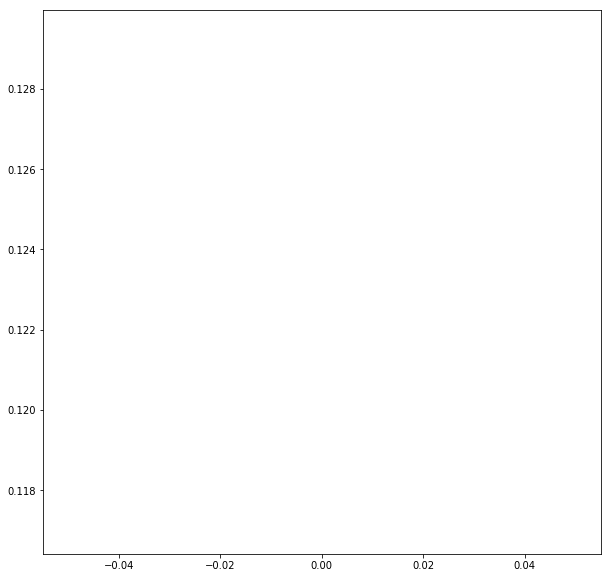

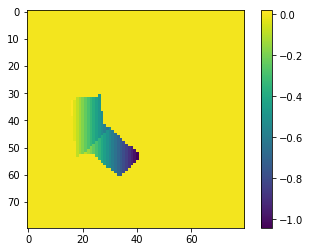

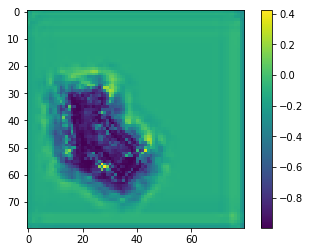

 10%|█         | 50/500 [00:18<02:29,  3.01it/s]

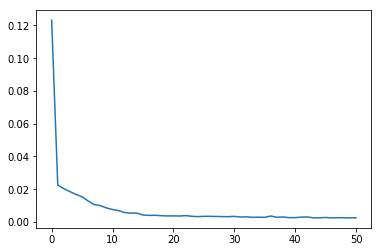

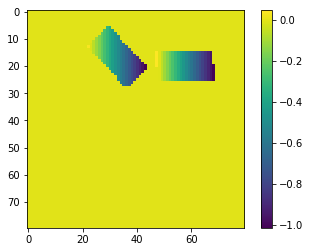

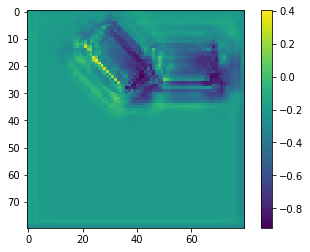

 20%|██        | 100/500 [00:35<02:13,  3.00it/s]

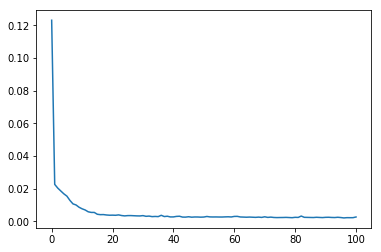

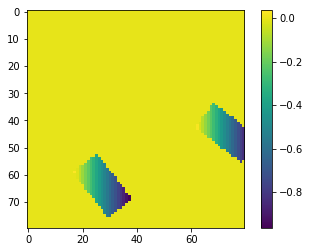

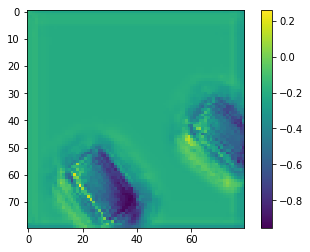

 30%|███       | 150/500 [00:52<01:55,  3.03it/s]

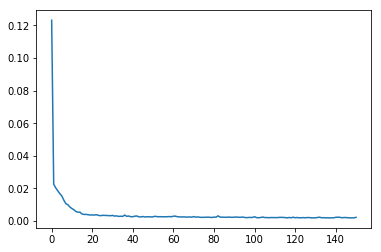

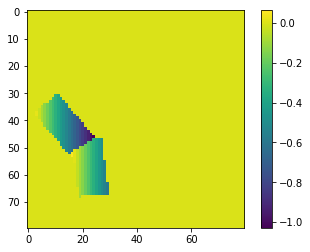

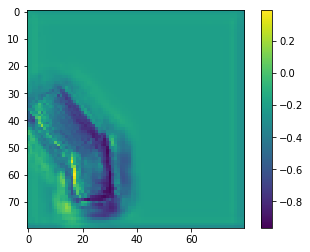

 40%|████      | 200/500 [01:09<01:39,  3.01it/s]

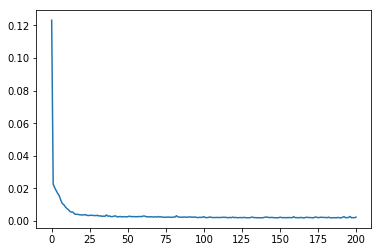

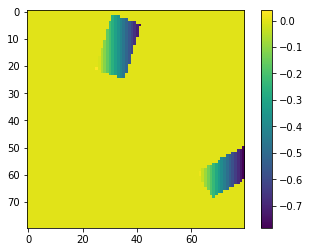

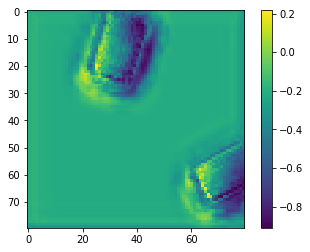

 50%|█████     | 250/500 [01:26<01:22,  3.02it/s]

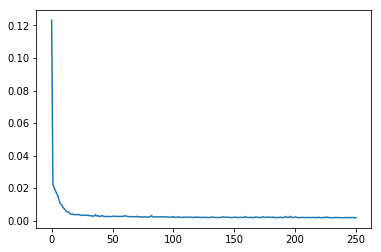

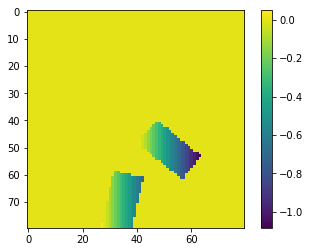

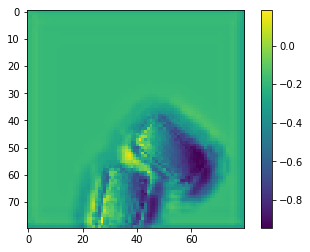

 60%|██████    | 300/500 [01:43<01:10,  2.83it/s]

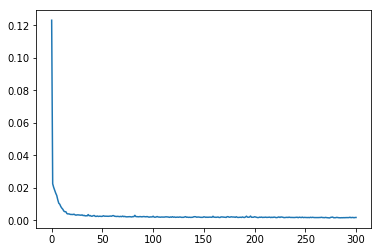

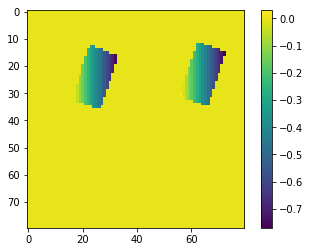

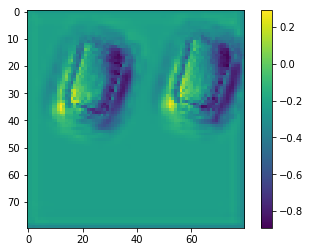

 70%|███████   | 350/500 [02:00<00:53,  2.79it/s]

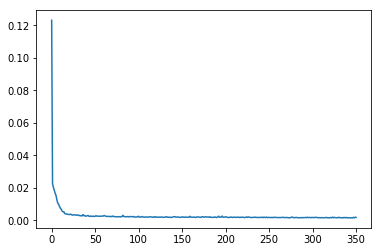

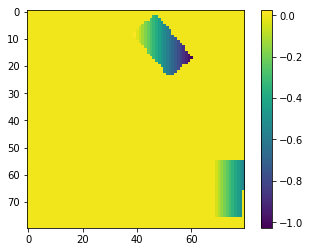

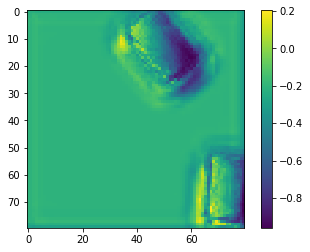

 80%|████████  | 400/500 [02:17<00:33,  3.02it/s]

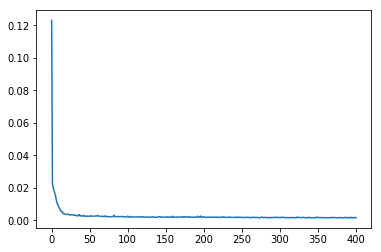

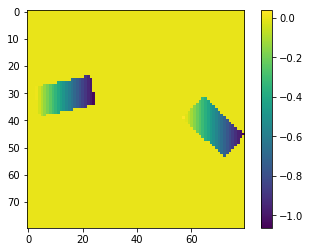

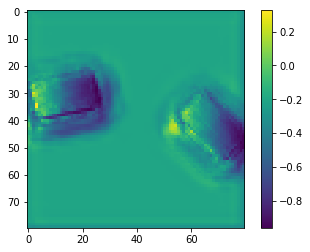

 90%|█████████ | 450/500 [02:35<00:16,  3.01it/s]

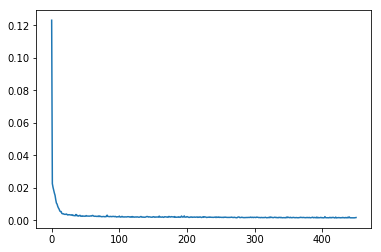

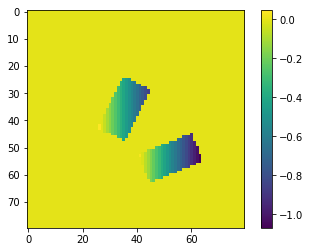

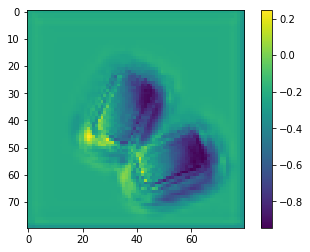

100%|██████████| 500/500 [02:52<00:00,  3.01it/s]


In [6]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))
dimensions =[80.0,40.0]
norm_factor = 20.0

# Training for loop
for i in tqdm(range(500)):
    imgs, labels = db.generate_batch(num=5, h=dimensions[0], w=dimensions[1], image_size=320)
    imgs_down, labels_down = fr.downsample(imgs, labels)
    
    net.to_gpu(0)

    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
    gt_class, gt_loc = fr.encode_y(imgs_down,norm_factor , labels_down) #cpu
    
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    # Forward pass: SLOW!!!
    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

#     class_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1.0)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 50 == 0:
        gt_loc.to_cpu()
        pred_loc.to_cpu()
        plt.plot(range(len(losses)), losses)
        plt.show()
        plt.figure()
        plt.imshow(gt_loc[0,0,:,:].data,)
        plt.colorbar()
        plt.show()


        plt.figure()
        plt.imshow(pred_loc[0,0,:,:].data,)
        plt.colorbar()
        plt.show()
    
    
# Final loss plot


In [7]:
imgs, labels = db.generate_batch(num=5, h=dimensions[0], w=dimensions[1], image_size=320)
imgs_down, labels_down = fr.downsample(imgs, labels)
    
imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
gt_class, gt_loc = fr.encode_y(imgs_down,norm_factor , labels_down) #cpu
    
gt_class.to_gpu(0)
gt_loc.to_gpu(0)

    # Forward pass: SLOW!!!
pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
   

In [8]:
# db = SquaresDataset()
# imgs, labels = db.generate_batch(n=10, h=50, w=50, img_h=240, img_w=240)
# imgs_down, labels_down = downsample(imgs, labels)
gt_loc.to_cpu()
pred_loc.to_cpu()




# for i in range(5):
#     for c in range(4):
#         plt.title("gt_loc_image_%d_%d"%(i, c))
#         plt.imshow(gt_loc[i,c,:,:].data,)
#         plt.colorbar()
#         plt.show()
        
#         plt.title("gt_loc_hist_%d_%d"%(i, c))
#         plt.hist(gt_loc[i,c,:,:].data.ravel()) 
#         plt.show()
        
#         plt.title("pred_loc_image_%d_%d"%(i, c))
#         plt.imshow(pred_loc[i,c,:,:].data)
#         plt.colorbar()
#         plt.show()
        
#         plt.title("pred_loc_hist_%d_%d"%(i, c))
#         plt.hist(pred_loc[i,c,:,:].data.ravel())
#         plt.show()
    
        

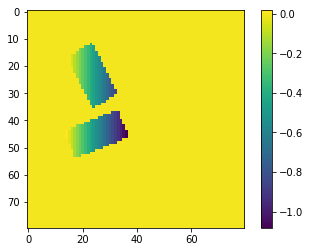

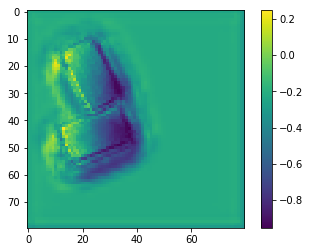

In [9]:
plt.figure()
plt.imshow(gt_loc[0,0,:,:].data,)
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(pred_loc[0,0,:,:].data,)
plt.colorbar()
plt.show()

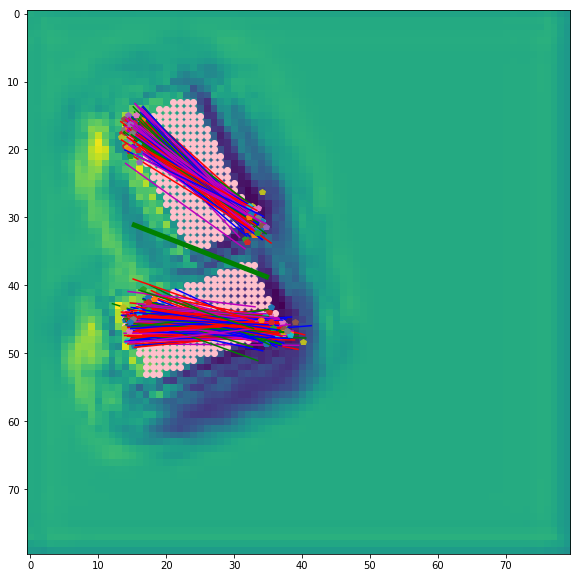

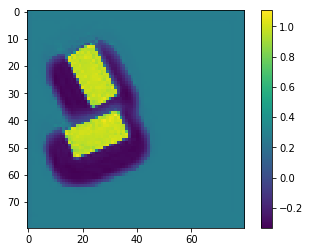

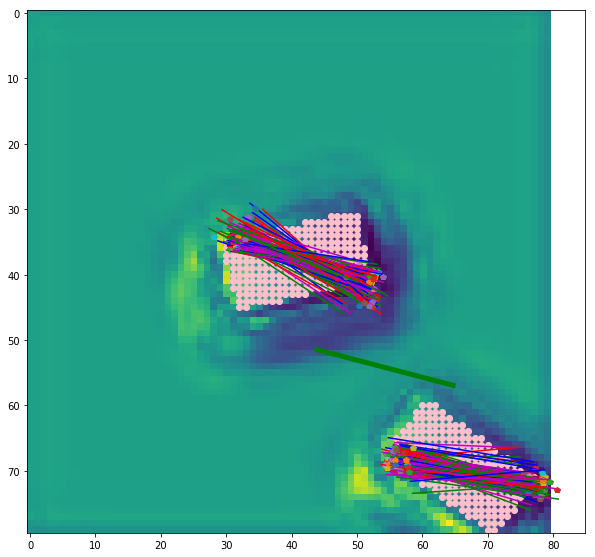

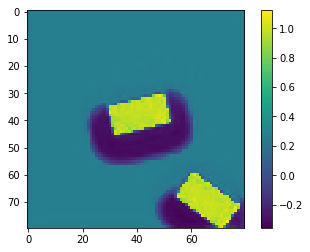

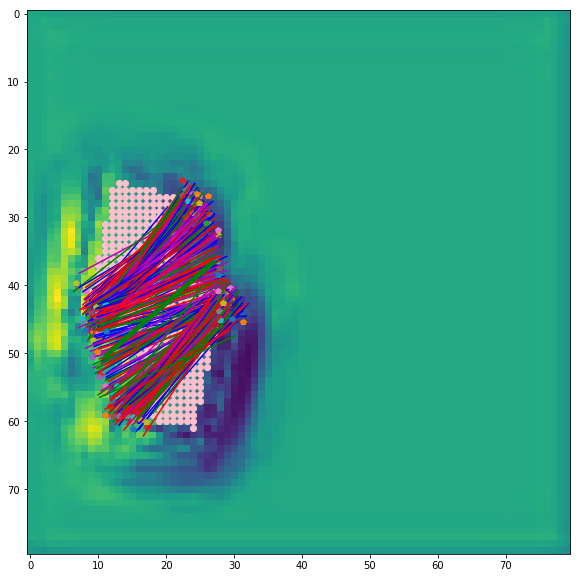

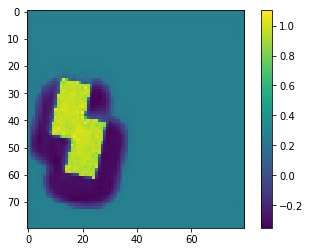

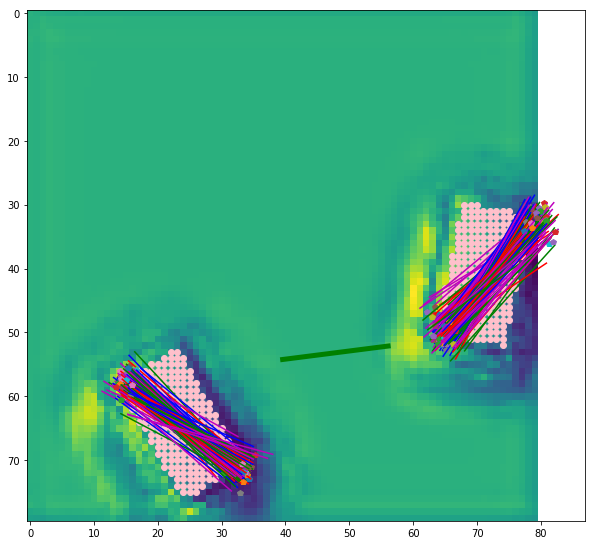

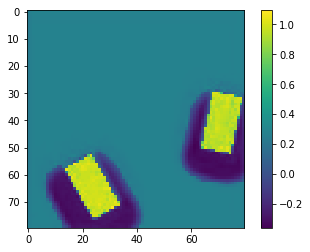

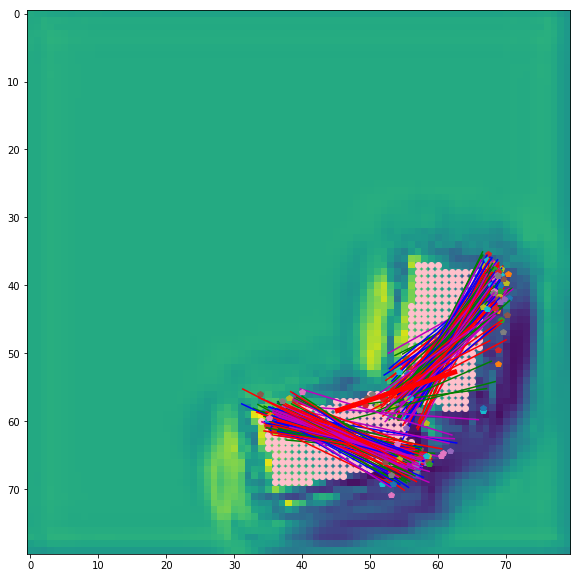

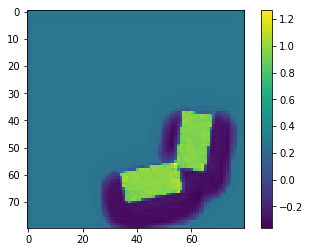

In [104]:
pred_class.to_cpu()
import matplotlib as mt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

pix_loc = [30,30]

# change image number to change the first pred channel
store_box_coords = []
for img_number in range(pred_loc.shape[0]):
    
    img_num= img_number

    
    mean_value = pred_class[img_num,0,:,:].data
    mean_value = np.mean(mean_value)
    
    sorty,sortx,val = np.where(pred_class[img_num,:,:,:].data>mean_value)
    pred_class_data = pred_class.data

    
    # find the value of the largest value 
    sortedval = np.where(pred_class_data[img_num,:,:,:]>mean_value )

    # array where you have [pred_class value, index_x, index_y]
    sortedval_array = np.array((pred_class_data[img_num,:,sortedval[1],sortedval[2]].squeeze(),sortedval[1],sortedval[2]))

    # max valued indices on top
    max_value_indices = np.flipud(np.argsort(sortedval_array[0,:]))

    # pick the first 10 of max values 
    subset_indicies = sortedval_array[:,max_value_indices[0:10]]


    pty =subset_indicies[1,:]
    ptx = subset_indicies[2,:]

    mean_value = pred_class[img_num,0,:,:].data
    mean_value = np.mean(mean_value)
    pty, ptx = np.where(pred_class[img_num,0,:,:].data>0.7)
    
    if(pty.shape[0]>100): 
        ptx= ptx
        pty= pty

    # plot pred_loc
    plt.figure(figsize=(10,10))
    ax = plt.axes()
    plt.imshow(pred_loc[img_num,0,:,:].data)
   
    
    box_coordinates_array=  np.zeros((pty.shape[0],4))
    
    for i in range(pty.shape[0]):
        pix_x = ptx[i]
        pix_y = pty[i]

        single_box = pred_loc[img_num,:,pix_y,pix_x]


        box_coordinates = [pix_x+norm_factor*single_box[0].data,
                                   pix_y+norm_factor*single_box[1].data, 
                                   pix_x+norm_factor*single_box[2].data, 
                                    pix_y+norm_factor*single_box[3].data]
        
        store_box_coords.append(box_coordinates)
        for box_coord in range(4):
            box_coordinates_array[i,box_coord]= np.array(box_coordinates[box_coord])
    
        # plot lines 
    
        plt.scatter(pix_x, pix_y, c='pink')
        plt.plot([box_coordinates[0],box_coordinates[2] ],[box_coordinates[1],box_coordinates[3]],np.random.choice(['r', 'g', 'b', 'm','p']))
   
    box_coord_mean = np.mean(box_coordinates_array, axis=0)    
    plt.plot([box_coord_mean[0],box_coord_mean[2] ],[box_coord_mean[1],box_coord_mean[3]],np.random.choice(['r', 'g']),lw= 5 )
    
        
    # plot pred class
    
    plt.figure()
    plt.imshow( pred_class[img_num,0,:,:].data)
    plt.colorbar()
    plt.show()

    
    
    

In [ ]:
%env http_proxy http://proxy.ncbs.res.in:3128
%env https_proxy http://proxy.ncbs.res.in:3128

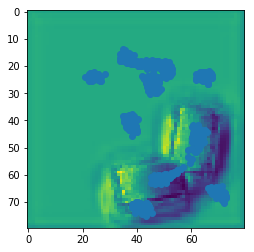

In [103]:
store_box_array= np.array(store_box_coords)
mean_x= np.mean((store_box_array[:,0],store_box_array[:,2]), axis=0)
mean_y =np.mean((store_box_array[:,1],store_box_array[:,3]), axis= 0)
box_centers = np.stack((mean_x,mean_y))

plt.figure()
plt.imshow(pred_loc[-1,0,:,:].data)
plt.scatter(mean_y,mean_x )
plt.show()


In [16]:
import numpy as np

from sklearn.datasets.samples_generator import make_blobs

X = StandardScaler().fit_transform(store_box_array)


In [74]:
X.shape
db = DBSCAN(eps=1.24, min_samples=30).fit(X)


In [75]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


array([0, 1])